In [1]:
# 1. Create a massive list of possible activation functions
# 2. Iteratively create a graph for the target network using random activations and connectivity
# 3. See how well neural networks of different sizes and activation functions can solve it
#    Here I'm really just looking for diversity in the solutions.
# 4. Then try the same thing, but connect all hidden units to the output.
# 5. Try the same thing, but use all of the hidden units generated by all units.


# Progression of things to look at:
# - Initializations
# - Activations
# - Sparsity
# - Small world sparsity

In [2]:
import random
from typing import Any, Dict, List, Optional, Type, Tuple

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sparselinear as sl
import torch
from torch import nn
import torch.optim as optim
from torch.nn import functional as F

from phd.feature_search.core.idbd import IDBD
from phd.feature_search.core.models.base import LTU, FTA
from phd.feature_search.core.experiment_helpers import StandardizationStats, standardize_targets

In [3]:
class SinActivation(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.sin(x)
    
class NormActivation(nn.Module):
    def __init__(self, decay_rate: float = 0.99):
        super().__init__()
        self.stats = StandardizationStats(gamma=decay_rate)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out, self.stats = standardize_targets(x, self.stats)
        return out

In [4]:
activation_functions = {
    'relu': nn.ReLU,
    'sigmoid': nn.Sigmoid,
    'tanh': nn.Tanh,
    'elu': nn.ELU,
    'leaky_relu': nn.LeakyReLU,
    'swish': nn.SiLU,
    'gelu': nn.GELU,
    'selu': nn.SELU,
    'softplus': nn.Softplus,
    'softsign': nn.Softsign,
    'linear': nn.Identity,
    'ltu': LTU,
    'fta': FTA,
    'sin': SinActivation,
    'norm': NormActivation,
}

In [5]:
class RandomNetwork(nn.Module):
    def __init__(
        self,
        input_dim: int,
        n_hidden_activations: int,
        activation_functions: Dict[str, Type[nn.Module]],
    ):
        super().__init__()
        self.input_dim = input_dim
        self.n_hidden_activations = n_hidden_activations
        self.activation_functions = activation_functions
        self.max_connections_per_node = input_dim // 2
        
        self.activations, self.node_input_ids = self._generate_random_network(
            input_dim, n_hidden_activations, self.max_connections_per_node, activation_functions)
        
        n_inputs_per_node = torch.tensor([len(ids) for ids in self.node_input_ids])
        bounds = torch.sqrt(3 / n_inputs_per_node).reshape(n_hidden_activations, 1, 1) # Kaiming uniform
        self.weights = torch.rand(n_hidden_activations, 1, self.max_connections_per_node) * 2 * bounds - bounds
        self.weights = nn.Parameter(self.weights)
    
    def _generate_random_network(
        self,
        input_dim: int,
        n_hidden_activations: int,
        max_connections_per_node: int,
        activation_functions: Dict[str, Type[nn.Module]],
    ) -> Tuple[List[nn.Module], List[List[int]]]:
        """Generates a random network structure with specified input dimension and number of hidden activations.
        
        Args:
            input_dim: Number of input dimensions
            n_hidden_activations: Number of hidden activation nodes to generate
            activation_functions: Dictionary mapping activation names to activation classes
            
        Returns:
            Tuple containing:
                - List of activation modules
                - List of input indices for each activation node
        """
        n_hidden_units = input_dim
        activations = []
        node_input_ids = []
        
        for i in range(n_hidden_activations):
            activation_type = random.choice(list(activation_functions.keys()))
            n_inputs = random.randint(1, input_dim)
            if activation_type == 'fta':
                activations.append(FTA(1))
                n_outputs = 20
            else:
                activations.append(activation_functions[activation_type]())
                n_outputs = 1
            
            n_connections = random.randint(1, max_connections_per_node)
            input_ids = random.sample(range(n_hidden_units), n_connections)
            node_input_ids.append(input_ids)
            n_hidden_units += n_outputs
            
        return activations, node_input_ids

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        all_values = inputs.clone() # (batch_size, input_dim)
        for i, activation in enumerate(self.activations):
            values = all_values[:, self.node_input_ids[i]] # (batch_size, n_node_inputs)
            weights = self.weights[i, :, :values.shape[1]] # (1, n_node_inputs)
            preactivation = values @ weights.T # (batch_size, 1)
            postactivation = activation(preactivation)
            all_values = torch.cat([all_values, postactivation], dim=1)
        print(all_values.shape)
        return all_values

In [6]:
def create_mlp(
    layer_sizes: List[int],
    activation_class: Type[nn.Module],
    sparsity_rate: float = 0.0,
    small_world_sparsity: bool = False,
    bias: bool = True,
    seed: Optional[int] = None,
) -> nn.Sequential:
    """Create a Multi-Layer Perceptron (MLP) with specified architecture.
    
    Args:
        layer_sizes: List of integers representing the size of each layer,
            including input and output layers. For example, [784, 128, 64, 10]
            creates a network with input size 784, two hidden layers of 128 and 64
            neurons, and output size 10.
        activation_class: PyTorch activation function class (e.g., nn.ReLU,
            nn.Tanh, nn.Sigmoid, nn.LeakyReLU).
        sparsity_rate: The sparsity rate to apply to the linear layers.
        bias: Whether to include bias terms in linear layers.
        seed: Optional random seed for reproducibility.
    
    Returns:
        nn.Sequential: A PyTorch Sequential model representing the MLP.
    
    Raises:
        ValueError: If layer_sizes has fewer than 2 elements (input and output).
        ValueError: If any layer size is not positive.
    """
    if len(layer_sizes) < 2:
        raise ValueError(
            "layer_sizes must contain at least 2 elements (input and output)"
        )
    
    if any(size <= 0 for size in layer_sizes):
        raise ValueError("All layer sizes must be positive integers")
    
    if seed is not None:
        torch.manual_seed(seed)
    
    layers = []
    
    for i in range(len(layer_sizes) - 1):
        # Add linear layer
        if sparsity_rate > 0:
            new_layer = sl.SparseLinear(
                in_features = layer_sizes[i],
                out_features = layer_sizes[i + 1],
                bias = bias and i < len(layer_sizes) - 2,
                sparsity = sparsity_rate,
                small_world = small_world_sparsity,
            )
        else:
            new_layer = nn.Linear(
                in_features = layer_sizes[i],
                out_features = layer_sizes[i + 1],
                bias = bias and i < len(layer_sizes) - 2,
            )
        
        layers.append(new_layer)
        
        # Add activation function (except for the last layer)
        if i < len(layer_sizes) - 2:
            layers.append(activation_class())
    
    return nn.Sequential(*layers)

In [7]:
def train_model(
    model: nn.Module,
    train_inputs: torch.Tensor,
    train_outputs: torch.Tensor,
    repr_step_size: float,
    batch_size: int,
    print_freq: int = 1000,
    log_freq: int = 1000,
) -> Tuple[List[float], List[float]]:
    """Train a model and return training and test losses."""
    # output_optimizer = IDBD(
    #     params = model[-1].parameters(),
    #     meta_lr = 0.005,
    #     init_lr = 0.01,
    #     version = 'squared_grads',
    #     autostep = True,
    # )
    # if len(model) > 1:
    repr_optimizer = optim.Adam(model.parameters(), lr=repr_step_size)
    # else:
    #     repr_optimizer = None
    
    train_losses = []
    errors = []
    
    n_train_batches = len(train_inputs) // batch_size
    
    running_train_loss = 0.0
    print_loss_sum = 0.0
    step = 0
    
    for step in range(n_train_batches):
        # Get batch
        start_idx = step * batch_size
        end_idx = start_idx + batch_size
            
        batch_inputs = train_inputs[start_idx:end_idx]
        batch_outputs = train_outputs[start_idx:end_idx]
        
        outputs = model(batch_inputs)
        loss = F.mse_loss(outputs, batch_outputs)
        
        with torch.no_grad():
            batch_errors = (batch_outputs - outputs).view(-1).tolist()
            errors.extend(batch_errors)
        
        # Backward pass
        # output_optimizer.zero_grad()
        if repr_optimizer is not None:
            repr_optimizer.zero_grad()
        
        loss.backward() # retain_graph=True)
        
        # output_optimizer.step(outputs)
        if repr_optimizer is not None:
            repr_optimizer.step()
        
        # Accumulate running loss
        running_train_loss += loss.item()
        print_loss_sum += loss.item()
        
        if (step + 1) % print_freq == 0:
            print(f"Step {step+1}: Loss = {print_loss_sum / print_freq:.6f}")
            print_loss_sum = 0.0
        
        # Log periodically
        if (step + 1) % log_freq == 0:
            # Calculate average training loss
            avg_train_loss = running_train_loss / log_freq
            train_losses.append(avg_train_loss)
            
            # Reset running stats
            running_train_loss = 0.0
    
    return {
        'losses': train_losses,
        'errors': errors,
    }

In [8]:
def plot_1var_ablation_results(
    results_dict: Dict[Any, Dict[str, List[float]]],
    ablation_variable: str,
    figsize: Tuple[int, int] = (10, 6)
):
    """Plot training curves comparing different values of a single ablated variable.
    
    Args:
        results_dict: Dictionary mapping ablation values to results_dict containing
            'losses' list
        ablation_variable: Name of the variable that was ablated
        figsize: Figure size (width, height) in inches
    """
    # Extract unique ablation values
    ablation_values = sorted(list(results_dict.keys()))
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)
    
    # Define colors for different ablation values
    colors = plt.cm.Set1(np.linspace(0, 1, len(ablation_values)))
    
    # Find global min and max for consistent axis limits
    all_losses = []
    for result in results_dict.values():
        all_losses.extend(result['losses'])

    y_min = min(all_losses)
    y_max = max(all_losses)

    # Add padding to y-axis, using multiplicative padding for log scale
    y_min = y_min / 1.5  # Divide by >1 to extend lower bound
    y_max = y_max * 1.1  # Multiply by >1 to extend upper bound

    # Get number of steps from first result's losses length
    n_steps = len(next(iter(results_dict.values()))['losses'])
    steps = list(range(1, n_steps + 1))

    # Plot each ablation value with a different color
    for i, ablation_val in enumerate(ablation_values):
        result = results_dict[ablation_val]
        losses = result['losses']
        
        ax.plot(steps, losses, 
                label=f'{ablation_variable}={ablation_val}', 
                color=colors[i], 
                alpha=0.8,
                linewidth=2)
    
    ax.set_xlabel('Step')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training Loss vs {ablation_variable}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Set y-axis to log scale
    ax.set_yscale('log')
    
    # Set consistent axis limits
    ax.set_ylim(y_min, y_max)
    ax.set_xlim(1, n_steps)

    plt.tight_layout()
    plt.show()

    # Print final results summary
    print("\nFinal Results Summary:")
    print("=" * 50)
    for ablation_val in ablation_values:
        result = results_dict[ablation_val]
        final_loss = result['losses'][-1]
        print(f"{ablation_variable}={ablation_val}  --  Final Loss: {final_loss:.6f}")


def plot_2var_ablation_results(
    results_dict: Dict[Tuple[Any, Any], Dict[str, List[float]]],
    row_variable: str,
    col_variable: str,
    figsize: Tuple[int, int] = (15, 12)
):
    """Plot a grid of training curves comparing different model configurations.
    
    Args:
        results_dict: Dictionary mapping (row_val, col_val) tuples to results_dict containing
            'train_losses' and 'test_losses' lists
        row_variable: Name of the variable that varies across rows
        col_variable: Name of the variable that varies across columns
        figsize: Figure size (width, height) in inches
    """
    # Extract unique values for rows and columns
    row_values = sorted(list({r for r, _ in results_dict.keys()}))
    col_values = sorted(list({c for _, c in results_dict.keys()}))
    
    # Create figure and axes grid
    fig, axes = plt.subplots(
        len(row_values), len(col_values),
        figsize=figsize, sharex=True, sharey=True
    )
    
    # Ensure axes is always 2D
    if len(row_values) == 1:
        axes = axes.reshape(1, -1)
    if len(col_values) == 1:
        axes = axes.reshape(-1, 1)

    # Find global min and max for consistent axis limits
    all_losses = []
    for result in results_dict.values():
        all_losses.extend(result['losses'])

    y_min = min(all_losses)
    y_max = max(all_losses)

    # Add padding to y-axis, using multiplicative padding for log scale
    y_min = y_min / 1.5  # Divide by >1 to extend lower bound
    y_max = y_max * 1.1  # Multiply by >1 to extend upper bound

    # Get number of steps from first result's losses length
    n_steps = len(next(iter(results_dict.values()))['losses'])
    steps = list(range(1, n_steps + 1))

    for i, row_val in enumerate(row_values):
        for j, col_val in enumerate(col_values):
            ax = axes[i, j]
            
            result = results_dict[(row_val, col_val)]
            losses = result['losses']
            
            ax.plot(steps, losses, label='Loss', color='blue', alpha=0.7)
            
            ax.set_title(f'{row_variable}={row_val}, {col_variable}={col_val}')
            ax.set_xlabel('Step')
            ax.set_ylabel('Loss')
            ax.legend()
            ax.grid(True, alpha=0.3)
            
            # Set y-axis to log scale
            ax.set_yscale('log')
            
            # Set consistent axis limits
            ax.set_ylim(y_min, y_max)
            ax.set_xlim(1, n_steps)

    plt.tight_layout()
    plt.show()

    # Print final results summary
    print("\nFinal Results Summary:")
    print("=" * 50)
    for row_val in row_values:
        for col_val in col_values:
            result = results_dict[(row_val, col_val)]
            final_loss = result['losses'][-1]
            print(f"{row_variable}={row_val}, {col_variable}={col_val}  --  Final Loss: {final_loss:.6f}")

In [9]:
def plot_1var_error_correlations(
    results_dict: Dict[Any, Dict[str, List[float]]],
    ablation_variable: str,
    figsize: Tuple[int, int] = (8, 6)
) -> None:
    """Plot a heatmap showing correlations between error sequences for different ablation values.
    
    Args:
        results_dict: Dictionary mapping ablation values to results containing 'errors' lists
        ablation_variable: Name of the variable that was ablated
        figsize: Figure size (width, height) in inches
    """
    # Create labels for each configuration
    configs = []
    error_sequences = []
    
    for ablation_val in results_dict.keys():
        configs.append(f"{ablation_variable}={ablation_val}")
        error_sequences.append(results_dict[ablation_val]['errors'])
    
    n_configs = len(configs)
    correlations = np.zeros((n_configs, n_configs))
    
    # Compute pairwise correlations
    for i in range(n_configs):
        for j in range(n_configs):
            corr = np.corrcoef(error_sequences[i], error_sequences[j])[0,1]
            correlations[i,j] = corr
            
    # Create heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(
        correlations,
        xticklabels=configs,
        yticklabels=configs,
        vmin=0,
        vmax=1,
        cmap='viridis',
        annot=True,
        fmt='.2f'
    )
    
    plt.title(f'Pairwise Error Sequence Correlations - {ablation_variable}')
    plt.tight_layout()
    plt.show()


def plot_2var_error_correlations(
    results_dict: Dict[Tuple[Any, Any], Dict[str, List[float]]],
    row_variable: str,
    col_variable: str,
    figsize: Tuple[int, int] = (10, 8)
) -> None:
    """Plot a heatmap showing correlations between error sequences for different model configs.
    
    Args:
        results_dict: Dictionary mapping (row_val, col_val) tuples to results containing 'errors' lists
        row_variable: Name of the variable that varies across rows 
        col_variable: Name of the variable that varies across columns
        figsize: Figure size (width, height) in inches
    """
    # Create labels for each configuration
    configs = []
    error_sequences = []
    
    for row_val, col_val in results_dict.keys():
        configs.append(f"{row_variable}={row_val}\n{col_variable}={col_val}")
        error_sequences.append(results_dict[(row_val, col_val)]['errors'])
    
    n_configs = len(configs)
    correlations = np.zeros((n_configs, n_configs))
    
    # Compute pairwise correlations
    for i in range(n_configs):
        for j in range(n_configs):
            corr = np.corrcoef(error_sequences[i], error_sequences[j])[0,1]
            correlations[i,j] = corr
            
    # Create heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(
        correlations,
        xticklabels=configs,
        yticklabels=configs,
        vmin=0,
        vmax=1,
        cmap='viridis',
        annot=True,
        fmt='.2f'
    )
    
    plt.title('Pairwise Error Sequence Correlations')
    plt.tight_layout()
    plt.show()

In [10]:
input_dim = 20
n_hidden_activations = 20

# Create a random target network
target_network = RandomNetwork(
    input_dim, n_hidden_activations, activation_functions)

n_samples = 20_000

inputs = torch.randn(n_samples, input_dim)
with torch.no_grad():
    outputs = target_network(inputs)[:, -1:]

torch.Size([20000, 78])


## Different initializatons

In [11]:
batch_size = 1

activation_cls = nn.ReLU
n_layers = 3
hidden_dim = 100
seeds = [0, 1, 2, 3, 4, 5, 6]

# Run experiments
results = {}
for seed in seeds:
    print(f"\nTraining model with seed {seed}...")
    
    # Create layer sizes
    layer_sizes = [input_dim] + [hidden_dim] * (n_layers - 1) + [outputs.shape[1]]
    # Create model
    model = create_mlp(layer_sizes, activation_cls, seed=seed)
    learning_rate = 0.02 / hidden_dim ** 0.5
    
    # Train model
    losses = train_model(
        model, inputs, outputs,
        repr_step_size = learning_rate,
        batch_size = 1,
        log_freq = 200,
        print_freq = 2000,
    )
    
    # Store results
    results[str(seed)] = losses


Training model with seed 0...
Step 2000: Loss = 0.088200
Step 4000: Loss = 0.067778
Step 6000: Loss = 0.058522
Step 8000: Loss = 0.050504
Step 10000: Loss = 0.044432
Step 12000: Loss = 0.040051
Step 14000: Loss = 0.037221
Step 16000: Loss = 0.037756
Step 18000: Loss = 0.039091
Step 20000: Loss = 0.033636

Training model with seed 1...
Step 2000: Loss = 0.090251
Step 4000: Loss = 0.070310
Step 6000: Loss = 0.060465
Step 8000: Loss = 0.052313
Step 10000: Loss = 0.049824
Step 12000: Loss = 0.043088
Step 14000: Loss = 0.040140
Step 16000: Loss = 0.036498
Step 18000: Loss = 0.038070
Step 20000: Loss = 0.031644

Training model with seed 2...
Step 2000: Loss = 0.088568
Step 4000: Loss = 0.069364
Step 6000: Loss = 0.059296
Step 8000: Loss = 0.054436
Step 10000: Loss = 0.051433
Step 12000: Loss = 0.043247
Step 14000: Loss = 0.039486
Step 16000: Loss = 0.038366
Step 18000: Loss = 0.039868
Step 20000: Loss = 0.035528

Training model with seed 3...
Step 2000: Loss = 0.090317
Step 4000: Loss = 0.0

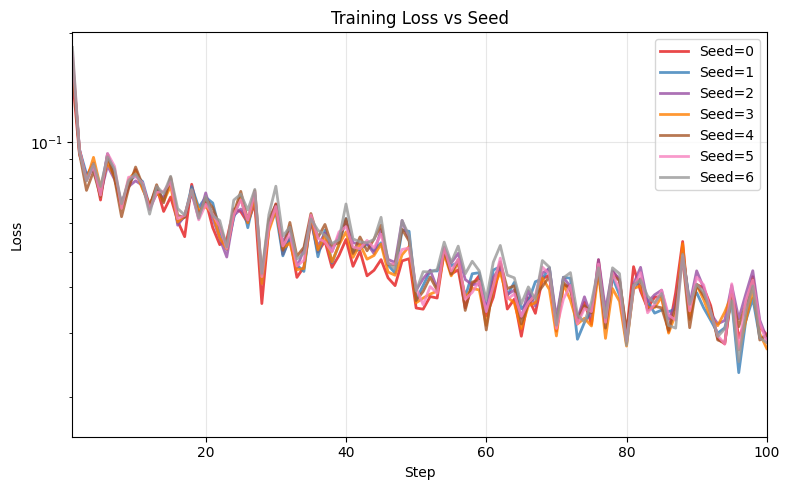


Final Results Summary:
Seed=0  --  Final Loss: 0.029639
Seed=1  --  Final Loss: 0.029474
Seed=2  --  Final Loss: 0.028916
Seed=3  --  Final Loss: 0.027138
Seed=4  --  Final Loss: 0.029574
Seed=5  --  Final Loss: 0.028197
Seed=6  --  Final Loss: 0.028173


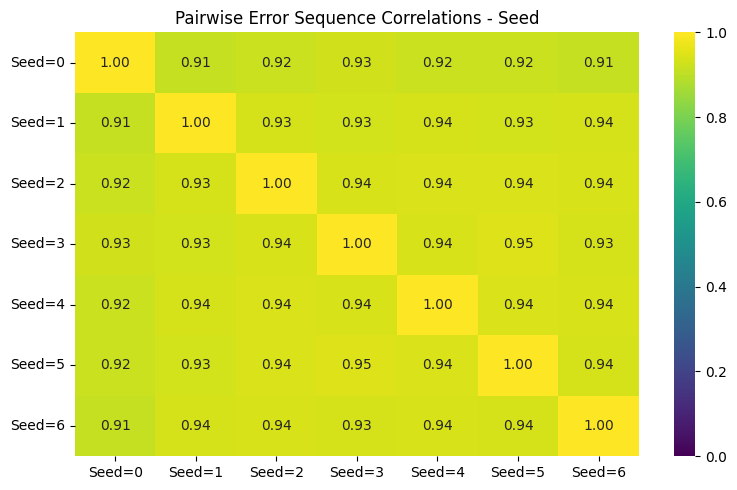

In [12]:
plot_1var_ablation_results(results, 'Seed', figsize=(8, 5))
plt.show()

plot_1var_error_correlations(results, 'Seed', figsize=(8, 5))
plt.show()

## Different activations

In [13]:
batch_size = 1

n_layers = 3
hidden_dim = 100
activation_classes = [nn.ReLU, nn.SiLU, nn.Tanh, LTU, SinActivation, nn.LeakyReLU, nn.SELU, nn.Sigmoid]

# Run experiments
results = {}
for activation_cls in activation_classes:
    print(f"\nTraining model with {activation_cls.__name__} activation...")
    
    # Create layer sizes
    layer_sizes = [input_dim] + [hidden_dim] * (n_layers - 1) + [outputs.shape[1]]
    # Create model
    model = create_mlp(layer_sizes, activation_cls, seed=7292025)
    learning_rate = 0.02 / hidden_dim ** 0.5
    
    # Train model
    losses = train_model(
        model, inputs, outputs,
        repr_step_size = learning_rate,
        batch_size = 1,
        log_freq = 200,
        print_freq = 2000,
    )
    
    # Store results
    results[activation_cls.__name__] = losses


Training model with ReLU activation...
Step 2000: Loss = 0.087478
Step 4000: Loss = 0.070326
Step 6000: Loss = 0.061238
Step 8000: Loss = 0.054789
Step 10000: Loss = 0.049368
Step 12000: Loss = 0.042738
Step 14000: Loss = 0.039186
Step 16000: Loss = 0.037988
Step 18000: Loss = 0.039933
Step 20000: Loss = 0.033795

Training model with SiLU activation...
Step 2000: Loss = 0.084111
Step 4000: Loss = 0.068563
Step 6000: Loss = 0.061666
Step 8000: Loss = 0.059589
Step 10000: Loss = 0.059702
Step 12000: Loss = 0.052564
Step 14000: Loss = 0.048672
Step 16000: Loss = 0.045044
Step 18000: Loss = 0.045926
Step 20000: Loss = 0.035425

Training model with Tanh activation...
Step 2000: Loss = 0.100021
Step 4000: Loss = 0.089420
Step 6000: Loss = 0.081052
Step 8000: Loss = 0.080089
Step 10000: Loss = 0.071829
Step 12000: Loss = 0.054137
Step 14000: Loss = 0.057406
Step 16000: Loss = 0.052204
Step 18000: Loss = 0.050682
Step 20000: Loss = 0.044882

Training model with LTU activation...
Step 2000: Lo

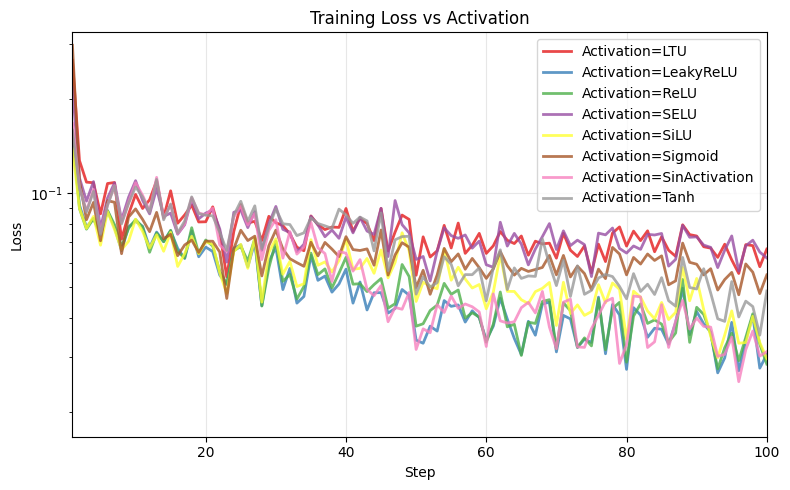


Final Results Summary:
Activation=LTU  --  Final Loss: 0.066299
Activation=LeakyReLU  --  Final Loss: 0.030519
Activation=ReLU  --  Final Loss: 0.028425
Activation=SELU  --  Final Loss: 0.062124
Activation=SiLU  --  Final Loss: 0.029573
Activation=Sigmoid  --  Final Loss: 0.054818
Activation=SinActivation  --  Final Loss: 0.031150
Activation=Tanh  --  Final Loss: 0.048681


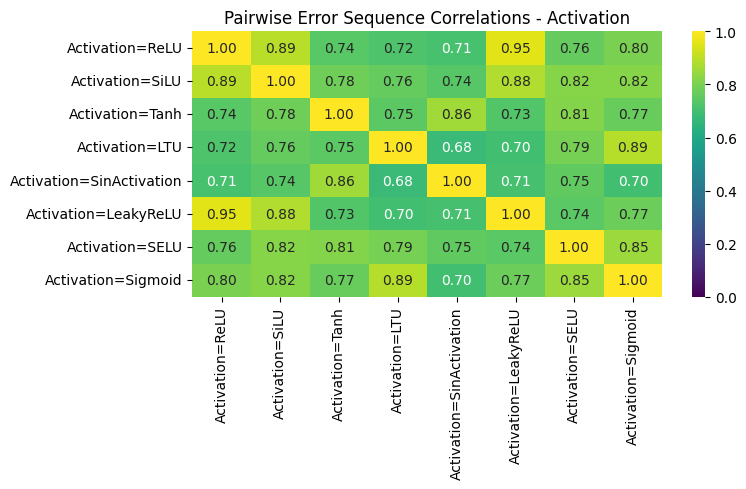

In [14]:
plot_1var_ablation_results(results, 'Activation', figsize=(8, 5))
plt.show()

plot_1var_error_correlations(results, 'Activation', figsize=(8, 5))
plt.show()

## Different sparsity rates

In [ ]:
batch_size = 1

n_layers = 3
hidden_dim = 100
activation_cls = nn.ReLU
sparsity_rates = [0.0, 0.5, 0.9, 0.95, 0.99]

# Run experiments
results = {}
for sparsity_rate in sparsity_rates:
    print(f"\nTraining model with {sparsity_rate} sparsity rate...")
    
    # Create layer sizes
    expanded_hidden_dim = int(round((hidden_dim**2 / (1 - sparsity_rate))**0.5, 4))
    layer_sizes = [input_dim] + [expanded_hidden_dim] * (n_layers - 1) + [outputs.shape[1]]
    
    # Create model
    model = create_mlp(
        layer_sizes,
        activation_cls,
        seed=7292025,
        sparsity_rate = sparsity_rate,
        small_world_sparsity = False,
    )
    learning_rate = 0.02 / (expanded_hidden_dim * (1.0 - sparsity_rate)) ** 0.5
    
    # Train model
    losses = train_model(
        model, inputs, outputs,
        repr_step_size = learning_rate,
        batch_size = 1,
        log_freq = 200,
        print_freq = 2000,
    )
    
    # Store results
    results[sparsity_rate] = losses


Training model with 0.0 sparsity rate...
Step 2000: Loss = 0.087478
Step 4000: Loss = 0.070326
Step 6000: Loss = 0.061238
Step 8000: Loss = 0.054789
Step 10000: Loss = 0.049368
Step 12000: Loss = 0.042738
Step 14000: Loss = 0.039186
Step 16000: Loss = 0.037988
Step 18000: Loss = 0.039933
Step 20000: Loss = 0.033795

Training model with 0.5 sparsity rate...
Step 2000: Loss = 0.085278
Step 4000: Loss = 0.063153
Step 6000: Loss = 0.053308
Step 8000: Loss = 0.046224
Step 10000: Loss = 0.039962
Step 12000: Loss = 0.035101
Step 14000: Loss = 0.034793
Step 16000: Loss = 0.035007
Step 18000: Loss = 0.037230
Step 20000: Loss = 0.031573

Training model with 0.9 sparsity rate...
Step 2000: Loss = 0.094223
Step 4000: Loss = 0.059436
Step 6000: Loss = 0.053001
Step 8000: Loss = 0.049733
Step 10000: Loss = 0.047985
Step 12000: Loss = 0.045317
Step 14000: Loss = 0.046756
Step 16000: Loss = 0.046778
Step 18000: Loss = 0.049157
Step 20000: Loss = 0.045157

Training model with 0.95 sparsity rate...
Ste

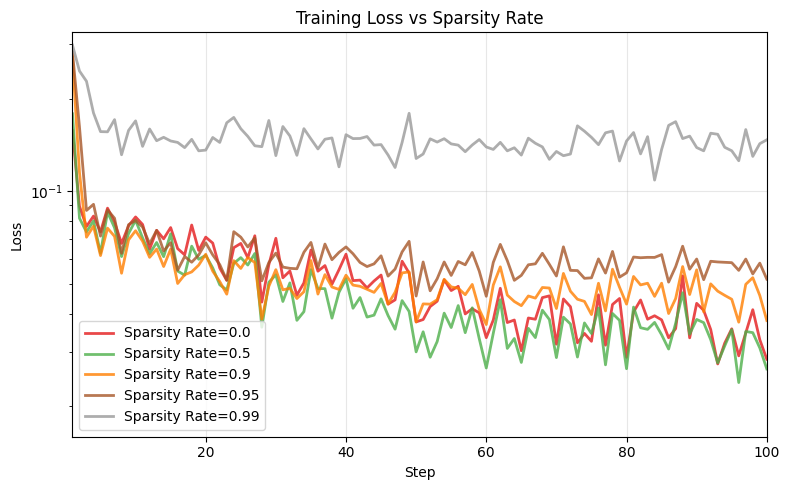


Final Results Summary:
Sparsity Rate=0.0  --  Final Loss: 0.028425
Sparsity Rate=0.5  --  Final Loss: 0.026428
Sparsity Rate=0.9  --  Final Loss: 0.037976
Sparsity Rate=0.95  --  Final Loss: 0.051758
Sparsity Rate=0.99  --  Final Loss: 0.146872


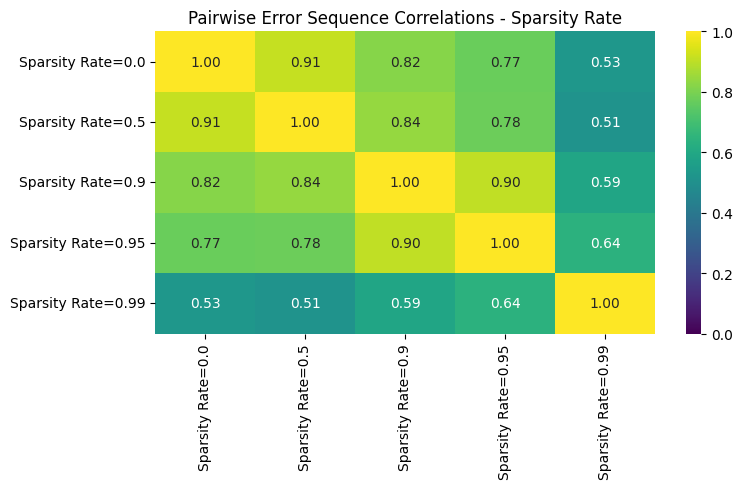

In [16]:
plot_1var_ablation_results(results, 'Sparsity Rate', figsize=(8, 5))
plt.show()

plot_1var_error_correlations(results, 'Sparsity Rate', figsize=(8, 5))
plt.show()

## Different small world sparsity rates

In [ ]:
batch_size = 1

n_layers = 3
hidden_dim = 100
activation_cls = nn.ReLU
sparsity_rates = [0.0, 0.5, 0.9, 0.95, 0.99]

# Run experiments
results = {}
for sparsity_rate in sparsity_rates:
    print(f"\nTraining model with {sparsity_rate} sparsity rate...")
    
    # Create layer sizes
    expanded_hidden_dim = int(round((hidden_dim**2 / (1 - sparsity_rate))**0.5, 4))
    layer_sizes = [input_dim] + [expanded_hidden_dim] * (n_layers - 1) + [outputs.shape[1]]
    
    # Create model
    model = create_mlp(
        layer_sizes,
        activation_cls,
        seed = 7292025,
        sparsity_rate = sparsity_rate,
        small_world_sparsity = True,
    )
    learning_rate = 0.02 / (expanded_hidden_dim * (1.0 - sparsity_rate)) ** 0.5
    
    # Train model
    losses = train_model(
        model, inputs, outputs,
        repr_step_size = learning_rate,
        batch_size = 1,
        log_freq = 200,
        print_freq = 2000,
    )
    
    # Store results
    results[sparsity_rate] = losses

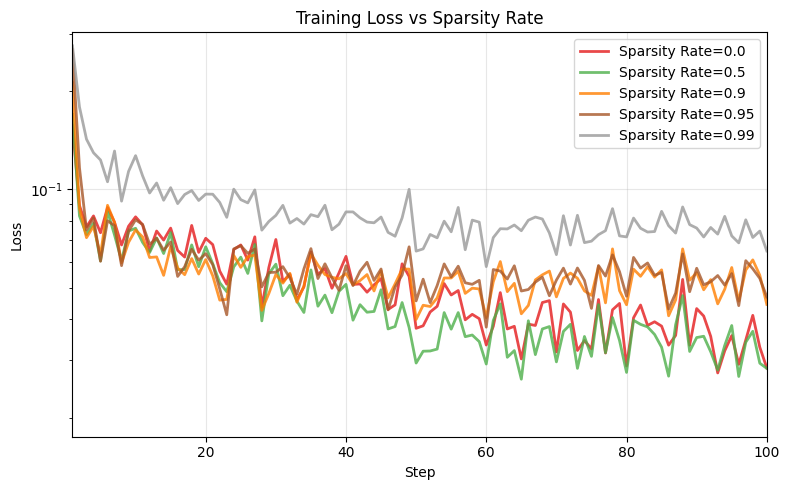


Final Results Summary:
Sparsity Rate=0.0  --  Final Loss: 0.028425
Sparsity Rate=0.5  --  Final Loss: 0.028332
Sparsity Rate=0.9  --  Final Loss: 0.044482
Sparsity Rate=0.95  --  Final Loss: 0.046858
Sparsity Rate=0.99  --  Final Loss: 0.064828


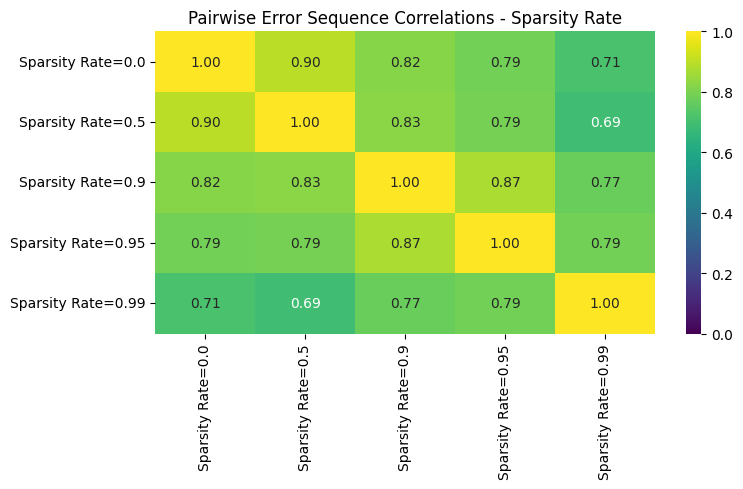

In [22]:
plot_1var_ablation_results(results, 'Sparsity Rate', figsize=(8, 5))
plt.show()

plot_1var_error_correlations(results, 'Sparsity Rate', figsize=(8, 5))
plt.show()